# Data Preparation & EDA Notebook



## 1. Data Understanding

The dataset used is the meteorological data from the HI-SEAS weather station in Hawaii for four months (September through December 2016) between Mission IV and Mission V. Hawaii's timezone is UTC -10 and they don' follow DST. I downloaded this dataset from Kaggle. Link is [https://www.kaggle.com/datasets/dronio/SolarEnergy/data](https://www.kaggle.com/datasets/dronio/SolarEnergy/data)

The fields are:

* A row number (1-n) useful in sorting this export's results
* The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results (UTC timezone)
* The date in yyyy-mm-dd format
* The local time of day in hh:mm:ss 24-hour format
* The numeric data, if any (may be an empty string)

There are 11 columns. No string data exists. Here's a gist of the metadata of the dataset

```
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 ```

 While data is read, the datetime columns are read as objects and hence processing them is done later. The units of each columns are:

- Solar radiation: watts per meter&sup2;

- Temperature: degrees Fahrenheit (&deg;F)

- Humidity: percent (%)

- Barometric pressure: Hg

- Wind direction: degrees (0 to 359.999999)

- Wind speed: miles per hour

- Sunrise/sunset: Hawaii time

Here is a sample row from the dataset

|UNIXTime|	Data|	Time|	Radiation|	Temperature|	Pressure|	Humidity|	WindDirection(Degrees)|	Speed|	TimeSunRise|	TimeSunSet|
|---------|-----|-------|------------|-------------|-----------|-------------|------------------------|------|-------------|---------------|
|1475229326|	9/29/2016 12:00:00 AM|	23:55:26|	1.21|	48	|30.46|	59	|177.39|	5.62|	06:13:00|	18:13:00|

My goal is the predict the solar radiation based on other features and hence its a regression problem. Its all a matter of figuring out the best regression model that can be used and tuning it

## 2. Data Preparation

Here is the Gist of data preparation I have done

* I have converted all column names to lowercase and removed special characters like '()'.
* The column unixtime is based on UTC and not local time while sun rise time, sun set time is based on local time.
* The column Data refers to the date when the data was collected (local time)
* Unixtime column is used for sorting and then discarded.
* Temperature, pressure, radiation, speed and humidity are numerical data thats linear in nature. Higher value means higher weight and they are scalar values.
* Radiation is the target feature
* Wind direction is a directional vector and hence higher value does not mean higher weights. Its from 0 to 359.999999.
* The duration between sunset time and sunrise time is the total time when sunlight was available. I calculated that and discarded the individual time entries.
* From the column 'Data' I extracted the day and month. From the column 'Time', I extracted hour and minutes.
* The day and month feature was used to engineer a new feature based on 1-366. Value 1 means Jan 1 of a year and 366 means Dec 31. Assumption is its always leap year.
* The hour and minute of recording is converted into a fractional time. E.g. 12 am is 0, 12 pm is 6, 12:30 pm is 6.5, etc.
* This data and the wind direction are both cyclical data. Higher value does not mean higher weights. A cyclical transformation was needed. For that, a sine and cosine value was calculated for both.
* The wind speed was combined with sine and cosine values since it is a scalar value.
* PCA was used to reduce the daylight duration feature and the day of the year (1-366) since they were closely correlated.

Finally, from 11 columns, I managed to reduce it to 9 columns including the target feature.

## 3. Data Processing Python Codes

## Data

In [2]:
# Primilimary checks

!python --version

Python 3.14.0


In [ ]:
# list of packages installed
!pip list

In [3]:
# I have used conda to manage packages. Check the version

!conda --version

conda 25.9.1


In [ ]:
# List of installed packages from conda's environment.yml file.
# After installing conda, use this command
!conda env create -f environment.yml

In [ ]:
# Activate the environemt mentioned in the yml file or create your own
# !conda activate <'env_name from yml file or your own'>

In [4]:
# All import commands

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Change the following values as needed.

In [5]:
# All constants here
DATA_LOCATION = '..\\Data\\'
FILE_NAME = 'InputFile'
FILE_TYPE ='.csv'
INTERMEDIARY_FILE = 'checking.csv'

# All variables here
df = []

In [ ]:
# Function to load the DF
def reload_df():
    global df
    df = pd.read_csv(DATA_LOCATION + FILE_NAME + FILE_TYPE)
reload_df()
df

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [8]:
# confirmation of Unix time accuracy

df['val_date'] = pd.to_datetime(df['UNIXTime'], unit='s')
df.columns = df.columns.str.lower()

# brackets present so...

df.rename(columns={'winddirection(degrees)': 'winddirection'}, inplace=True)
df

,unixtime,data,time,radiation,temperature,pressure,humidity,winddirection,speed,timesunrise,timesunset,val_date
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016-09-30 09:55:26
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016-09-30 09:50:23
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016-09-30 09:45:26
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016-09-30 09:40:21
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016-09-30 09:35:24
...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,2016-12-01 10:20:04
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,2016-12-01 10:15:01
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,2016-12-01 10:10:01
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,2016-12-01 10:05:02


In [9]:
# order by unix time

df.sort_values(by='unixtime', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,unixtime,data,time,radiation,temperature,pressure,humidity,winddirection,speed,timesunrise,timesunset,val_date
0,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00,2016-09-01 10:00:08
1,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00,2016-09-01 10:05:10
2,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00,2016-09-01 10:20:06
3,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00,2016-09-01 10:25:05
4,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00,2016-09-01 10:30:09
...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1483263302,12/31/2016 12:00:00 AM,23:35:02,1.22,41,30.34,83,238.94,6.75,06:57:00,17:54:00,2017-01-01 09:35:02
32682,1483263601,12/31/2016 12:00:00 AM,23:40:01,1.21,41,30.34,82,236.79,5.62,06:57:00,17:54:00,2017-01-01 09:40:01
32683,1483263904,12/31/2016 12:00:00 AM,23:45:04,1.21,42,30.34,81,218.28,7.87,06:57:00,17:54:00,2017-01-01 09:45:04
32684,1483264203,12/31/2016 12:00:00 AM,23:50:03,1.19,41,30.34,80,215.23,7.87,06:57:00,17:54:00,2017-01-01 09:50:03


In [10]:
# 1. Convert Time and Data into temporal data

df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['data'] = pd.to_datetime(df['data'], errors='coerce')

# 2. Extract the individual components using the .dt accessor
df['recorded_year'] = df['data'].dt.year
df['recorded_month'] = df['data'].dt.month
df['recorded_day'] = df['data'].dt.day
df['recorded_hour'] = df['time'].dt.hour
df['recorded_minute'] = df['time'].dt.minute
df['recorded_second'] = df['time'].dt.second

# Optional: Drop the columns
df.drop(columns = ['unixtime','data','time'],inplace=True)
df

C:\Users\User 1\AppData\Local\Temp\ipykernel_2196\2414340880.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'], errors='coerce')
C:\Users\User 1\AppData\Local\Temp\ipykernel_2196\2414340880.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['data'] = pd.to_datetime(df['data'], errors='coerce')


,radiation,temperature,pressure,humidity,winddirection,speed,timesunrise,timesunset,val_date,recorded_year,recorded_month,recorded_day,recorded_hour,recorded_minute,recorded_second
0,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00,2016-09-01 10:00:08,2016,9,1,0,0,8
1,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00,2016-09-01 10:05:10,2016,9,1,0,5,10
2,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00,2016-09-01 10:20:06,2016,9,1,0,20,6
3,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00,2016-09-01 10:25:05,2016,9,1,0,25,5
4,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00,2016-09-01 10:30:09,2016,9,1,0,30,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,238.94,6.75,06:57:00,17:54:00,2017-01-01 09:35:02,2016,12,31,23,35,2
32682,1.21,41,30.34,82,236.79,5.62,06:57:00,17:54:00,2017-01-01 09:40:01,2016,12,31,23,40,1
32683,1.21,42,30.34,81,218.28,7.87,06:57:00,17:54:00,2017-01-01 09:45:04,2016,12,31,23,45,4
32684,1.19,41,30.34,80,215.23,7.87,06:57:00,17:54:00,2017-01-01 09:50:03,2016,12,31,23,50,3


In [11]:
# 1. Convert sunrise and sunset time into temporal data to calculate difference
df['Sunrise_TD'] = pd.to_timedelta(df['timesunrise'])
df['Sunset_TD'] = pd.to_timedelta(df['timesunset'])

# 2. Calculate the difference to get the total duration of daylight
df['Daylight_Duration_TD'] = df['Sunset_TD'] - df['Sunrise_TD']

# 3. Convert the duration to a numerical feature (Total Hours)
# This is the ideal format for machine learning models.
df['daylight_hours'] = df['Daylight_Duration_TD'].dt.total_seconds() / 3600

df['timesunrise'] = pd.to_datetime(df['timesunrise'], errors='coerce')
df['timesunset'] = pd.to_datetime(df['timesunset'], errors='coerce')

# 4. Extract the individual components using the .dt accessor
df['sunrise_hour'] = df['timesunrise'].dt.hour
df['sunrise_minutes'] = df['timesunrise'].dt.minute
df['sunrise_seconds'] = df['timesunrise'].dt.second
df['sunset_hour'] = df['timesunset'].dt.hour
df['sunset_minutes'] = df['timesunset'].dt.minute
df['sunset_seconds'] = df['timesunset'].dt.second

# Optional: Drop the intermediate datetime column if you don't need it
df.drop(columns = ['timesunrise','timesunset','val_date','Sunrise_TD','Sunset_TD','Daylight_Duration_TD'],inplace=True)

df

C:\Users\User 1\AppData\Local\Temp\ipykernel_2196\3415611561.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timesunrise'] = pd.to_datetime(df['timesunrise'], errors='coerce')
C:\Users\User 1\AppData\Local\Temp\ipykernel_2196\3415611561.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timesunset'] = pd.to_datetime(df['timesunset'], errors='coerce')


,radiation,temperature,pressure,humidity,winddirection,speed,recorded_year,recorded_month,recorded_day,recorded_hour,recorded_minute,recorded_second,daylight_hours,sunrise_hour,sunrise_minutes,sunrise_seconds,sunset_hour,sunset_minutes,sunset_seconds
0,2.58,51,30.43,103,77.27,11.25,2016,9,1,0,0,8,12.516667,6,7,0,18,38,0
1,2.83,51,30.43,103,153.44,9.00,2016,9,1,0,5,10,12.516667,6,7,0,18,38,0
2,2.16,51,30.43,103,142.04,7.87,2016,9,1,0,20,6,12.516667,6,7,0,18,38,0
3,2.21,51,30.43,103,144.12,18.00,2016,9,1,0,25,5,12.516667,6,7,0,18,38,0
4,2.25,51,30.43,103,67.42,11.25,2016,9,1,0,30,9,12.516667,6,7,0,18,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,238.94,6.75,2016,12,31,23,35,2,10.950000,6,57,0,17,54,0
32682,1.21,41,30.34,82,236.79,5.62,2016,12,31,23,40,1,10.950000,6,57,0,17,54,0
32683,1.21,42,30.34,81,218.28,7.87,2016,12,31,23,45,4,10.950000,6,57,0,17,54,0
32684,1.19,41,30.34,80,215.23,7.87,2016,12,31,23,50,3,10.950000,6,57,0,17,54,0


In [12]:
df.describe()

,radiation,temperature,pressure,humidity,winddirection,speed,recorded_year,recorded_month,recorded_day,recorded_hour,recorded_minute,recorded_second,daylight_hours,sunrise_hour,sunrise_minutes,sunrise_seconds,sunset_hour,sunset_minutes,sunset_seconds
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.0,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.0,32686.000000,32686.0,32686.000000,32686.000000,32686.0
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,2016.0,10.526066,15.825766,11.557425,27.556691,17.441902,11.509176,6.0,27.640519,0.0,17.347886,37.317904,0.0
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,0.0,1.096691,8.711824,6.912034,17.268507,12.951109,0.498854,0.0,15.518714,0.0,0.476307,15.938416,0.0
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,2016.0,9.000000,1.000000,0.000000,0.000000,0.000000,10.933333,6.0,7.000000,0.0,17.000000,0.000000,0.0
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,2016.0,10.000000,9.000000,6.000000,15.000000,5.000000,11.033333,6.0,14.000000,0.0,17.000000,26.000000,0.0
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,2016.0,11.000000,16.000000,12.000000,30.000000,18.000000,11.400000,6.0,24.000000,0.0,17.000000,43.000000,0.0
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,2016.0,11.000000,23.000000,18.000000,45.000000,22.000000,11.916667,6.0,40.000000,0.0,18.000000,48.000000,0.0
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,2016.0,12.000000,31.000000,23.000000,57.000000,59.000000,12.516667,6.0,57.000000,0.0,18.000000,59.000000,0.0


From the above decription, note the max and min values. For time, after hour 23, it is 0, after month 12 its 1, etc. Hence, cyclical transformation is needed

In [13]:
# Display the heatmap function
# 1. Calculate the Correlation Matrix
def heatmap():
    correlation_matrix = df.corr()

    # 2. Set up the Matplotlib figure
    plt.figure(figsize=(10, 10)) # Adjust size for readability

    # 3. Create the Heatmap using Seaborn
    sns.heatmap(
        correlation_matrix,
        annot=True,       # Show the correlation values on the heatmap
        fmt=".3f",        # Format the numbers to 2 decimal places
        cmap="coolwarm",  # Color map (cool to warm, for blue=negative, red=positive)
        cbar=True,        # Show the color bar
        linewidths=.5,    # Lines between cells
        linecolor='black', # Color of the lines
        annot_kws={"fontsize": 6.5}
    )

    # 4. Add a title and display the plot
    plt.title('Correlation Matrix Heatmap')
    plt.show() # In a notebook environment, use plt.show()

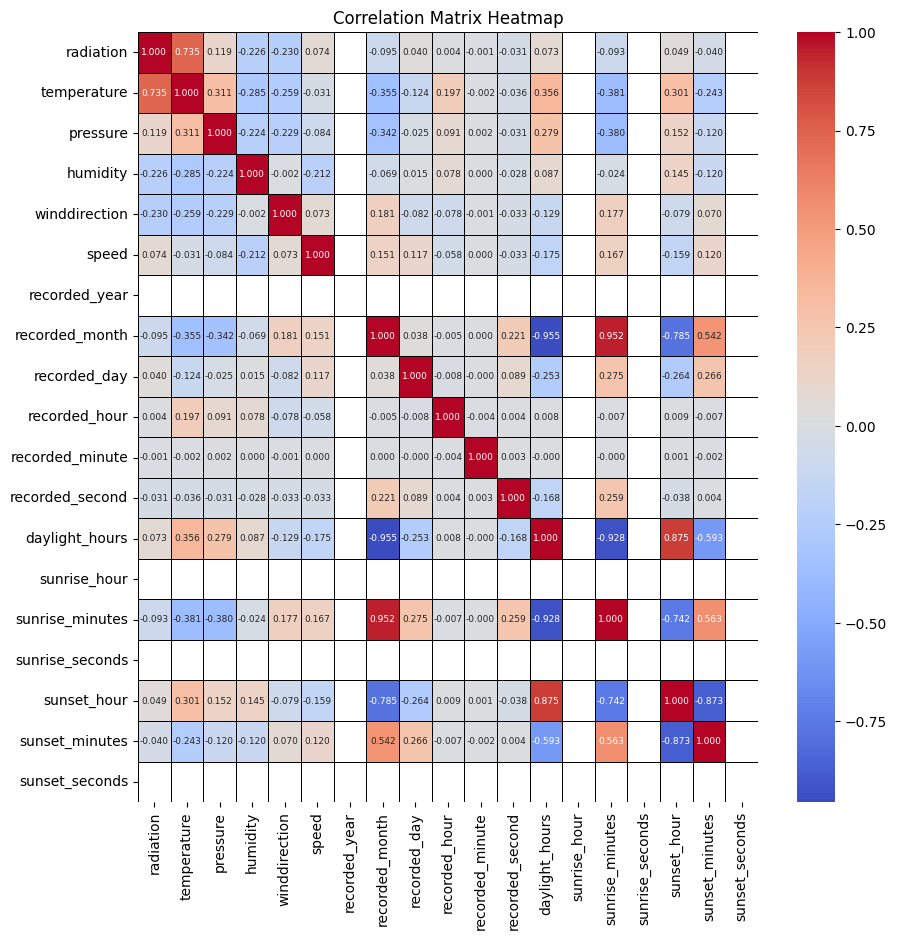

In [27]:
heatmap()

> The above heatmap is not accurate enough to be considered for cyclical data since I have not transformed it yet. This heatmap is to show the linear correlation between the values as if like they are linear in nature and shows the issues of not doing cyclical transformation. This is ok for linear data like temperature, humdity, wind speed, etc.

In [14]:
df.nunique()

radiation          14434
temperature           38
pressure              38
humidity              94
winddirection      17951
speed                 37
recorded_year          1
recorded_month         4
recorded_day          31
recorded_hour         24
recorded_minute       27
recorded_second       60
daylight_hours        75
sunrise_hour           1
sunrise_minutes       51
sunrise_seconds        1
sunset_hour            2
sunset_minutes        56
sunset_seconds         1
dtype: int64

In [15]:
# Full daylight time taken so sunrise and sunset time not needed
cols_to_drop = ['sunrise_minutes','sunset_hour','sunset_minutes']

# Iterate through all columns in the DataFrame
for col in df.columns:
    # nunique(dropna=False) counts unique values, including NaN/NaT if present.
    # We want to check if the non-missing values are all the same.
    # If dropna=True (default), it counts unique non-missing values.
    # Let's use dropna=True to capture the common case where a column is constant.
    if df[col].nunique(dropna=True) == 1:
        cols_to_drop.append(col)
        print(f"Identified column to drop: '{col}' (Unique Value: {df[col].iloc[0]})")
    
# Check if any columns were found and drop them
if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"\nSuccessfully dropped the following {len(cols_to_drop)} columns: {cols_to_drop}")
else:
    print("\nNo columns found with only one unique non-missing value. DataFrame remains unchanged.")

df

Identified column to drop: 'recorded_year' (Unique Value: 2016)
Identified column to drop: 'sunrise_hour' (Unique Value: 6)
Identified column to drop: 'sunrise_seconds' (Unique Value: 0)
Identified column to drop: 'sunset_seconds' (Unique Value: 0)

Successfully dropped the following 7 columns: ['sunrise_minutes', 'sunset_hour', 'sunset_minutes', 'recorded_year', 'sunrise_hour', 'sunrise_seconds', 'sunset_seconds']


,radiation,temperature,pressure,humidity,winddirection,speed,recorded_month,recorded_day,recorded_hour,recorded_minute,recorded_second,daylight_hours
0,2.58,51,30.43,103,77.27,11.25,9,1,0,0,8,12.516667
1,2.83,51,30.43,103,153.44,9.00,9,1,0,5,10,12.516667
2,2.16,51,30.43,103,142.04,7.87,9,1,0,20,6,12.516667
3,2.21,51,30.43,103,144.12,18.00,9,1,0,25,5,12.516667
4,2.25,51,30.43,103,67.42,11.25,9,1,0,30,9,12.516667
...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,238.94,6.75,12,31,23,35,2,10.950000
32682,1.21,41,30.34,82,236.79,5.62,12,31,23,40,1,10.950000
32683,1.21,42,30.34,81,218.28,7.87,12,31,23,45,4,10.950000
32684,1.19,41,30.34,80,215.23,7.87,12,31,23,50,3,10.950000


In [16]:
# Optional: occasional data check
def write_intermediary(filename=""):
    df.to_csv(DATA_LOCATION + (filename if filename else INTERMEDIARY_FILE), index=False)
    print('File written')

In [17]:
# to get fractional time
df['recorded_fractional_hour'] = (
    df['recorded_hour'] + 
    df['recorded_minute'] / 60 + 
    df['recorded_second'] / 3600
)
df.drop(columns=['recorded_hour','recorded_minute','recorded_second'], inplace=True)
df

,radiation,temperature,pressure,humidity,winddirection,speed,recorded_month,recorded_day,daylight_hours,recorded_fractional_hour
0,2.58,51,30.43,103,77.27,11.25,9,1,12.516667,0.002222
1,2.83,51,30.43,103,153.44,9.00,9,1,12.516667,0.086111
2,2.16,51,30.43,103,142.04,7.87,9,1,12.516667,0.335000
3,2.21,51,30.43,103,144.12,18.00,9,1,12.516667,0.418056
4,2.25,51,30.43,103,67.42,11.25,9,1,12.516667,0.502500
...,...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,238.94,6.75,12,31,10.950000,23.583889
32682,1.21,41,30.34,82,236.79,5.62,12,31,10.950000,23.666944
32683,1.21,42,30.34,81,218.28,7.87,12,31,10.950000,23.751111
32684,1.19,41,30.34,80,215.23,7.87,12,31,10.950000,23.834167


In [18]:
# 1. Create a placeholder column (using 2016 as the leap year base)
df['dummy_year'] = 2016 

# 2. Rename the columns temporarily to match pd.to_datetime expectations
# Create a mapping dictionary for renaming
rename_mapping = {
    'dummy_year': 'year', 
    'recorded_month': 'month', 
    'recorded_day': 'day'
}

# Create a new DataFrame with just the renamed columns for assembly
# Using a temporary DataFrame prevents modifying your original column names
date_components = df[['dummy_year', 'recorded_month', 'recorded_day']].rename(columns=rename_mapping)


# 3. Assemble the Datetime column
# Pandas now finds columns named 'year', 'month', and 'day' in date_components
df['RecordedDateTime'] = pd.to_datetime(date_components)


# 4. Extract the Day of the Year
df['day_of_year'] = df['RecordedDateTime'].dt.dayofyear


# 5. Clean up the intermediate columns
df.drop(columns=['dummy_year', 'RecordedDateTime','recorded_month','recorded_day'], inplace=True) 

print("Successfully created 'day_of_year' column.")
df

Successfully created 'day_of_year' column.


,radiation,temperature,pressure,humidity,winddirection,speed,daylight_hours,recorded_fractional_hour,day_of_year
0,2.58,51,30.43,103,77.27,11.25,12.516667,0.002222,245
1,2.83,51,30.43,103,153.44,9.00,12.516667,0.086111,245
2,2.16,51,30.43,103,142.04,7.87,12.516667,0.335000,245
3,2.21,51,30.43,103,144.12,18.00,12.516667,0.418056,245
4,2.25,51,30.43,103,67.42,11.25,12.516667,0.502500,245
...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,238.94,6.75,10.950000,23.583889,366
32682,1.21,41,30.34,82,236.79,5.62,10.950000,23.666944,366
32683,1.21,42,30.34,81,218.28,7.87,10.950000,23.751111,366
32684,1.19,41,30.34,80,215.23,7.87,10.950000,23.834167,366


In [19]:
# Define the maximum period of the cycle (24 hours in a day)
MAX_PERIOD = 24

# 1. Calculate the Sine (Y-coordinate) component
df['hour_sin'] = np.sin(2 * np.pi * df['recorded_fractional_hour'] / MAX_PERIOD)

# 2. Calculate the Cosine (X-coordinate) component
df['hour_cos'] = np.cos(2 * np.pi * df['recorded_fractional_hour'] / MAX_PERIOD)

print("Successfully created 'hour_sin' and 'hour_cos' features.")
df

Successfully created 'hour_sin' and 'hour_cos' features.


,radiation,temperature,pressure,humidity,winddirection,speed,daylight_hours,recorded_fractional_hour,day_of_year,hour_sin,hour_cos
0,2.58,51,30.43,103,77.27,11.25,12.516667,0.002222,245,0.000582,1.000000
1,2.83,51,30.43,103,153.44,9.00,12.516667,0.086111,245,0.022542,0.999746
2,2.16,51,30.43,103,142.04,7.87,12.516667,0.335000,245,0.087590,0.996157
3,2.21,51,30.43,103,144.12,18.00,12.516667,0.418056,245,0.109228,0.994017
4,2.25,51,30.43,103,67.42,11.25,12.516667,0.502500,245,0.131175,0.991359
...,...,...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,238.94,6.75,10.950000,23.583889,366,-0.108722,0.994072
32682,1.21,41,30.34,82,236.79,5.62,10.950000,23.666944,366,-0.087083,0.996201
32683,1.21,42,30.34,81,218.28,7.87,10.950000,23.751111,366,-0.065113,0.997878
32684,1.19,41,30.34,80,215.23,7.87,10.950000,23.834167,366,-0.043401,0.999058


In [20]:
sin_corr = df['radiation'].corr(df['hour_sin'])
cos_corr = df['radiation'].corr(df['hour_cos'])

print(f"Correlation between Radiation and hour_sin: {sin_corr:.9f}")
print(f"Correlation between Radiation and hour_cos: {cos_corr:.9f}")

Correlation between Radiation and hour_sin: -0.009495715
Correlation between Radiation and hour_cos: -0.762112548


## Interpreting the Hour Correlation

### 1. $\text{hour\_cos}$: The Strong Magnitude Signal

* **Correlation:** **-0.7621** (Strong Negative)
* **Interpretation:** This is my **primary predictor** for solar radiation magnitude.
    * When $\text{hour\_cos}$ is large and **negative** (close to -1.000 at **Noon/12:00**), the solar radiation is **high**.
    * When $\text{hour\_cos}$ is large and **positive** (close to +1.000 at **Midnight/00:00**), the solar radiation is **low (zero)**.
* **Conclusion:** This feature successfully captures the fundamental fact that the amount of sunlight is highest when the sun is highest in the sky (mid-day) and lowest when the sun is below the horizon (night).

---

### 2. $\text{hour\_sin}$: The Weak Directional Signal

* **Correlation:** **-0.0095** (Near Zero)
* **Interpretation:** This correlation is **intentionally weak** and close to zero
    * $\text{hour\_sin}$ is designed to **break the symmetry** between morning (positive $\text{sin}$) and afternoon (negative $\text{sin}$).
    * Since solar radiation levels are generally symmetric around solar noon (e.g., radiation at 9 AM is similar to radiation at 3 PM), the direct linear relationship between $\text{hour\_sin}$ alone and radiation should be negligible.
* **Conclusion:** The near-zero value confirms that the linear model cannot use $\text{hour\_sin}$ alone to predict radiation. However, in my **tree-based models (XGBoost/Random Forest)**, $\text{hour\_sin}$ is used as a crucial **split point** to determine if the time is AM or PM, allowing the model to correct for subtle non-symmetric effects (like morning cloud formation being more common than afternoon haze, or vice versa).

---

## Summary

These results **validate the feature engineering**:

* **Magnitude is Correct:** The $\text{hour\_cos}$ successfully provides the primary magnitude signal.
* **Direction is Unambiguous:** The $\text{hour\_sin}$ feature is necessary to provide the second coordinate, **preventing the model from confusing morning with afternoon**, even if its linear correlation is minimal.

In [21]:
# Define the maximum period of the cycle (360 degrees)
MAX_PERIOD = 360

# 1. Calculate the Sine (North/South component)
df['wind_dir_sin'] = np.sin(2 * np.pi * df['winddirection'] / MAX_PERIOD)

# 2. Calculate the Cosine (East/West component)
df['wind_dir_cos'] = np.cos(2 * np.pi * df['winddirection'] / MAX_PERIOD)
df

,radiation,temperature,pressure,humidity,winddirection,speed,daylight_hours,recorded_fractional_hour,day_of_year,hour_sin,hour_cos,wind_dir_sin,wind_dir_cos
0,2.58,51,30.43,103,77.27,11.25,12.516667,0.002222,245,0.000582,1.000000,0.975419,0.220357
1,2.83,51,30.43,103,153.44,9.00,12.516667,0.086111,245,0.022542,0.999746,0.447135,-0.894467
2,2.16,51,30.43,103,142.04,7.87,12.516667,0.335000,245,0.087590,0.996157,0.615111,-0.788440
3,2.21,51,30.43,103,144.12,18.00,12.516667,0.418056,245,0.109228,0.994017,0.586090,-0.810246
4,2.25,51,30.43,103,67.42,11.25,12.516667,0.502500,245,0.131175,0.991359,0.923344,0.383973
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,238.94,6.75,10.950000,23.583889,366,-0.108722,0.994072,-0.856627,-0.515935
32682,1.21,41,30.34,82,236.79,5.62,10.950000,23.666944,366,-0.087083,0.996201,-0.836669,-0.547709
32683,1.21,42,30.34,81,218.28,7.87,10.950000,23.751111,366,-0.065113,0.997878,-0.619505,-0.784993
32684,1.19,41,30.34,80,215.23,7.87,10.950000,23.834167,366,-0.043401,0.999058,-0.576860,-0.816843


In [22]:
sin_corr = df['radiation'].corr(df['wind_dir_sin'])
cos_corr = df['radiation'].corr(df['wind_dir_cos'])

print(f"Correlation between Radiation and wind_dir_sin: {sin_corr:.9f}")
print(f"Correlation between Radiation and wind_dir_cos: {cos_corr:.9f}")

Correlation between Radiation and wind_dir_sin: 0.106603555
Correlation between Radiation and wind_dir_cos: 0.569025064


## Interpreting the Wind Direction Correlation

### 1. $\text{wind\_dir\_cos}$: The Strong N/S Signal

* **Correlation:** **+0.5690** (Strong Positive)
* **Interpretation:** This component primarily represents the **Meridional (North-South)** movement of the wind vector.
    * A **positive correlation** means that when the $\text{wind\_dir\_cos}$ value is high, solar radiation is high.
    * The $\text{cos}$ value is highest when the angle is close to $0^\circ$ (North) and lowest at $180^\circ$ (South).
* **Crucial Interpretation:** This result suggests that wind flow with a significant **Northern component (Northward movement)** is strongly associated with higher solar radiation.

---

### 2. $\text{wind\_dir\_sin}$: The Weak E/W Signal

* **Correlation:** **+0.1066** (Weak Positive)
* **Interpretation:** This component primarily represents the **Zonal (East-West)** movement of the wind vector.
* **Conclusion:** The correlation is **very weak** (close to zero). The model shows that the East-West component of the wind vector contributes **very little** to the linear prediction of solar radiation. The primary climatic influence comes from whether the wind is moving North or South, not East or West.

---

## Summary: Why the Pair is Necessary

While $\text{wind\_dir\_cos}$ is clearly the most important factor, **both components** are needed:

* **Dominant Signal:** The strong correlation in $\text{wind\_dir\_cos}$ tells that the **North-South vector (Meridional flow)** is the most critical feature.
* **Symmetry Breaker:** The $\text{wind\_dir\_sin}$ (East-West vector) is necessary to **uniquely define the direction**. For example, a wind from the Northwest and a wind from the Northeast could have similar $\text{cos}$ values, but their $\text{sin}$ values would be opposite, allowing the model to distinguish between the two for more precise predictions.

This analysis validates the feature engineering choice, confirming that the wind vector approach correctly separates the dominant climatic signal (North-South) from the less relevant signal (East-West).

In [23]:
# drop columns since they are redundant
df.drop(columns=['recorded_fractional_hour','winddirection'], inplace=True)
df

,radiation,temperature,pressure,humidity,speed,daylight_hours,day_of_year,hour_sin,hour_cos,wind_dir_sin,wind_dir_cos
0,2.58,51,30.43,103,11.25,12.516667,245,0.000582,1.000000,0.975419,0.220357
1,2.83,51,30.43,103,9.00,12.516667,245,0.022542,0.999746,0.447135,-0.894467
2,2.16,51,30.43,103,7.87,12.516667,245,0.087590,0.996157,0.615111,-0.788440
3,2.21,51,30.43,103,18.00,12.516667,245,0.109228,0.994017,0.586090,-0.810246
4,2.25,51,30.43,103,11.25,12.516667,245,0.131175,0.991359,0.923344,0.383973
...,...,...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,6.75,10.950000,366,-0.108722,0.994072,-0.856627,-0.515935
32682,1.21,41,30.34,82,5.62,10.950000,366,-0.087083,0.996201,-0.836669,-0.547709
32683,1.21,42,30.34,81,7.87,10.950000,366,-0.065113,0.997878,-0.619505,-0.784993
32684,1.19,41,30.34,80,7.87,10.950000,366,-0.043401,0.999058,-0.576860,-0.816843


In [24]:
# 1. Calculate the full correlation matrix
correlation_matrix = df.corr()

# 2. Select the row corresponding to the 'radiation' column
# This gives the correlation of 'radiation' with every other feature
radiation_correlations = correlation_matrix['radiation']

# 3. Print the results (excluding radiation correlating with itself, which is 1.0)
print("--- Correlation with Radiation ---")
print(radiation_correlations.drop('radiation'))

--- Correlation with Radiation ---
temperature       0.734955
pressure          0.119016
humidity         -0.226171
speed             0.073627
daylight_hours    0.073456
day_of_year      -0.081320
hour_sin         -0.009496
hour_cos         -0.762113
wind_dir_sin      0.106604
wind_dir_cos      0.569025
Name: radiation, dtype: float64


-------------------------------------------------------------------------------------

Speed is a scalar value and can be combined with wind direction

-------------------------------------------------------------------------------------


In [25]:
# Assuming 'speed' is the raw wind speed column
# Note: The sin/cos components already include the necessary 2*pi/360 scaling from earlier steps

# U-Component (Zonal/East-West): Positive is usually West-to-East
df['zonal_wind_u'] = df['speed'] * df['wind_dir_sin']

# V-Component (Meridional/North-South): Positive is usually South-to-North
df['meridional_wind_v'] = df['speed'] * df['wind_dir_cos']

# Calculate correlation for the new vector components
u_corr = df['radiation'].corr(df['zonal_wind_u'])
v_corr = df['radiation'].corr(df['meridional_wind_v'])

print(f"Correlation between Radiation and Zonal Wind (U): {u_corr:.7f}")
print(f"Correlation between Radiation and Meridional Wind (V): {v_corr:.7f}")

df

Correlation between Radiation and Zonal Wind (U): 0.1171286
Correlation between Radiation and Meridional Wind (V): 0.5341914


,radiation,temperature,pressure,humidity,speed,daylight_hours,day_of_year,hour_sin,hour_cos,wind_dir_sin,wind_dir_cos,zonal_wind_u,meridional_wind_v
0,2.58,51,30.43,103,11.25,12.516667,245,0.000582,1.000000,0.975419,0.220357,10.973467,2.479016
1,2.83,51,30.43,103,9.00,12.516667,245,0.022542,0.999746,0.447135,-0.894467,4.024213,-8.050200
2,2.16,51,30.43,103,7.87,12.516667,245,0.087590,0.996157,0.615111,-0.788440,4.840925,-6.205026
3,2.21,51,30.43,103,18.00,12.516667,245,0.109228,0.994017,0.586090,-0.810246,10.549612,-14.584433
4,2.25,51,30.43,103,11.25,12.516667,245,0.131175,0.991359,0.923344,0.383973,10.387623,4.319697
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,6.75,10.950000,366,-0.108722,0.994072,-0.856627,-0.515935,-5.782236,-3.482564
32682,1.21,41,30.34,82,5.62,10.950000,366,-0.087083,0.996201,-0.836669,-0.547709,-4.702078,-3.078126
32683,1.21,42,30.34,81,7.87,10.950000,366,-0.065113,0.997878,-0.619505,-0.784993,-4.875505,-6.177892
32684,1.19,41,30.34,80,7.87,10.950000,366,-0.043401,0.999058,-0.576860,-0.816843,-4.539889,-6.428554


In [26]:
# drop redundant columns
cols_to_drop = ['wind_dir_sin','wind_dir_cos','speed']
df.drop(columns = cols_to_drop, inplace=True)
df

,radiation,temperature,pressure,humidity,daylight_hours,day_of_year,hour_sin,hour_cos,zonal_wind_u,meridional_wind_v
0,2.58,51,30.43,103,12.516667,245,0.000582,1.000000,10.973467,2.479016
1,2.83,51,30.43,103,12.516667,245,0.022542,0.999746,4.024213,-8.050200
2,2.16,51,30.43,103,12.516667,245,0.087590,0.996157,4.840925,-6.205026
3,2.21,51,30.43,103,12.516667,245,0.109228,0.994017,10.549612,-14.584433
4,2.25,51,30.43,103,12.516667,245,0.131175,0.991359,10.387623,4.319697
...,...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,10.950000,366,-0.108722,0.994072,-5.782236,-3.482564
32682,1.21,41,30.34,82,10.950000,366,-0.087083,0.996201,-4.702078,-3.078126
32683,1.21,42,30.34,81,10.950000,366,-0.065113,0.997878,-4.875505,-6.177892
32684,1.19,41,30.34,80,10.950000,366,-0.043401,0.999058,-4.539889,-6.428554


The daylight duration and calendar day maybe correlated since depending on the day of the year, the value oscillates. Lets test this theory.

In [27]:
# --- 1. Isolate the features ---
seasonal_features = ['daylight_hours', 'day_of_year']
seasonal_data = df[seasonal_features]

# --- 2. Scale the data (CRUCIAL STEP) ---
# PCA requires data to be standardized
scaler = StandardScaler()
seasonal_scaled = scaler.fit_transform(seasonal_data)

# --- 3. Apply PCA (Reduce 2 features to 1) ---
pca = PCA(n_components=1)
seasonal_pc1_array = pca.fit_transform(seasonal_scaled)

# --- 4. Create the new feature column ---
df['seasonal_pc1'] = seasonal_pc1_array

# --- 5. Report and Cleanup ---
variance_explained = pca.explained_variance_ratio_[0]

print(f"PCA on {seasonal_features} reduced to 1 component.")
print(f"Variance Explained by Seasonal_PC1: {variance_explained:.9f}")

df.drop(columns=seasonal_features,inplace=True)

df

PCA on ['daylight_hours', 'day_of_year'] reduced to 1 component.
Variance Explained by Seasonal_PC1: 0.989320360


,radiation,temperature,pressure,humidity,hour_sin,hour_cos,zonal_wind_u,meridional_wind_v,seasonal_pc1
0,2.58,51,30.43,103,0.000582,1.000000,10.973467,2.479016,2.670511
1,2.83,51,30.43,103,0.022542,0.999746,4.024213,-8.050200,2.670511
2,2.16,51,30.43,103,0.087590,0.996157,4.840925,-6.205026,2.670511
3,2.21,51,30.43,103,0.109228,0.994017,10.549612,-14.584433,2.670511
4,2.25,51,30.43,103,0.131175,0.991359,10.387623,4.319697,2.670511
...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,-0.108722,0.994072,-5.782236,-3.482564,-2.010188
32682,1.21,41,30.34,82,-0.087083,0.996201,-4.702078,-3.078126,-2.010188
32683,1.21,42,30.34,81,-0.065113,0.997878,-4.875505,-6.177892,-2.010188
32684,1.19,41,30.34,80,-0.043401,0.999058,-4.539889,-6.428554,-2.010188


The goal of this PCA was to reduce the redundancy between the two features that track the time of year:

* **`daylight_hours`**: The total hours of sunlight.
* **`day_of_year`**: The numerical day (1 to 365).

---

### 1. Variance Explained: $\mathbf{0.9893}$

The most critical number here is the **Variance Explained** of $\mathbf{0.9893}$ (or $\mathbf{98.93\%}$).

* This means the single new feature, **`Seasonal_PC1`**, successfully captures **98.93% of the total variability** that was contained in the two original features combined.
* **Conclusion:** The two original features were overwhelmingly redundant and highly correlated (as expected), and I have consolidated them into one optimized feature without losing virtually any valuable information.

---

### 2. Benefit to the Model

By keeping only `Seasonal_PC1` and dropping the two originals, I have achieved two major benefits:

* **Reduced Multicollinearity:** eliminated the problem of having two highly correlated features, which can destabilize the coefficients in linear models and occasionally confuse tree-based models.
* **Simplified Model:** reduced the total number of features used, which is crucial for building a simpler, more robust, and more interpretable model while maintaining high accuracy.

This result confirms that **`Seasonal_PC1` is a robust and highly efficient feature** for representing the seasonal context in the model.

Finally the data is as clean as possible. Lets check some final information before beginning the regression process

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   radiation          32686 non-null  float64
 1   temperature        32686 non-null  int64  
 2   pressure           32686 non-null  float64
 3   humidity           32686 non-null  int64  
 4   hour_sin           32686 non-null  float64
 5   hour_cos           32686 non-null  float64
 6   zonal_wind_u       32686 non-null  float64
 7   meridional_wind_v  32686 non-null  float64
 8   seasonal_pc1       32686 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 2.2 MB


In [29]:
df.describe()

,radiation,temperature,pressure,humidity,hour_sin,hour_cos,zonal_wind_u,meridional_wind_v,seasonal_pc1
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,-0.000993,0.000706,1.886346,-1.857141,0.000000
std,315.916387,6.201157,0.054673,25.990219,0.709667,0.704558,3.953855,5.341352,1.406663
min,1.110000,34.000000,30.190000,8.000000,-1.000000,-1.000000,-29.115856,-35.531953,-2.010188
25%,1.230000,46.000000,30.400000,56.000000,-0.708083,-0.706181,0.000000,-5.610554,-1.241493
50%,2.660000,50.000000,30.430000,85.000000,-0.002182,0.001345,1.753401,-2.220615,-0.152499
75%,354.235000,55.000000,30.460000,97.000000,0.708032,0.706078,4.141189,2.057191,1.169449
max,1601.260000,71.000000,30.560000,103.000000,1.000000,1.000000,19.842770,19.928081,2.670511


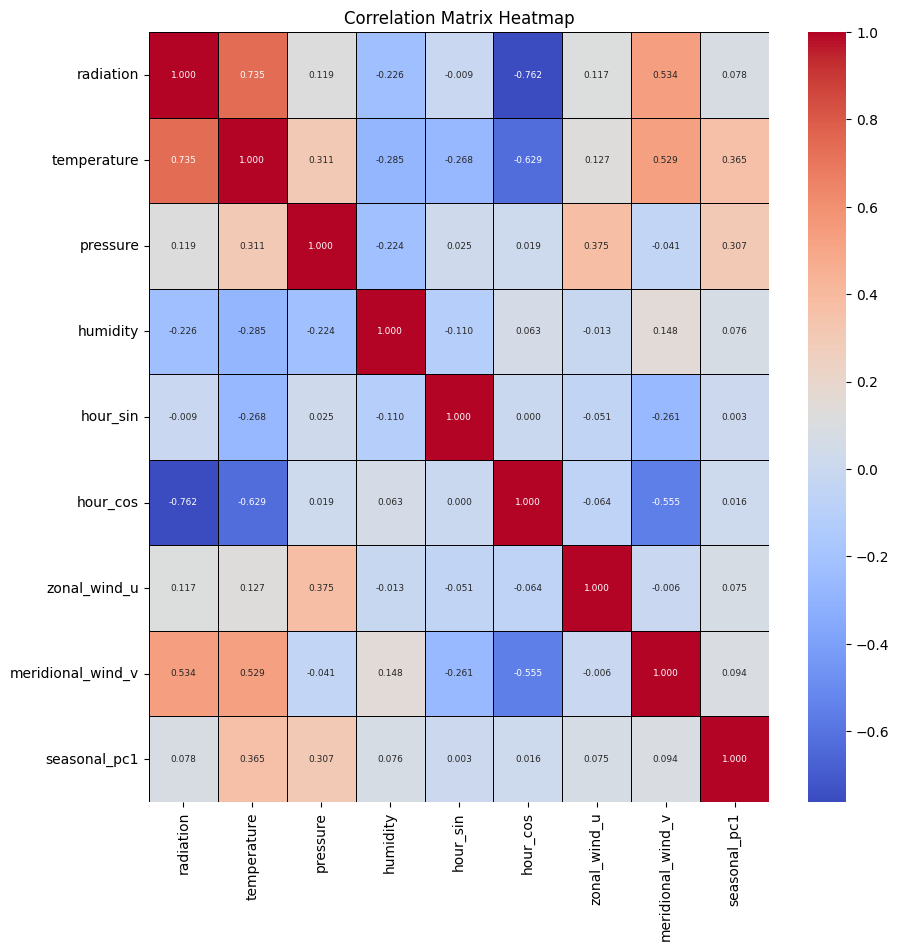

In [31]:
heatmap()

In [30]:
write_intermediary('Clean_Data.csv')

File written


## 4. Data Visualisations

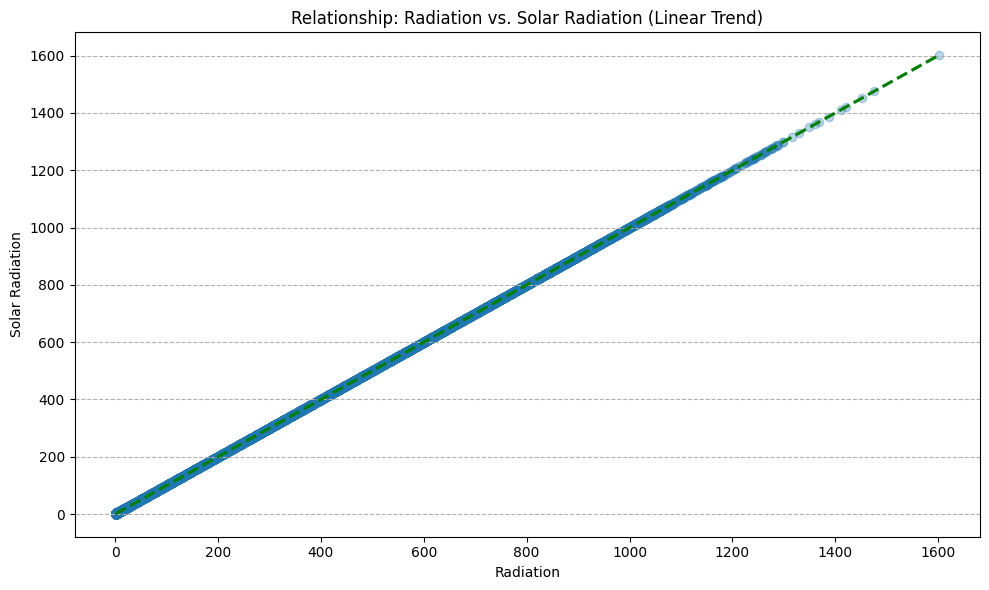

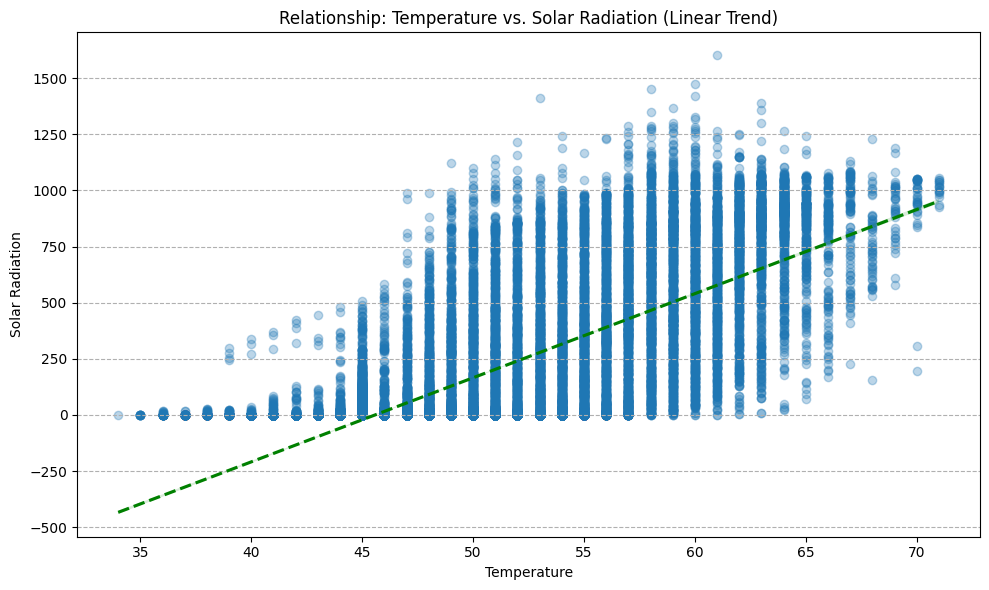

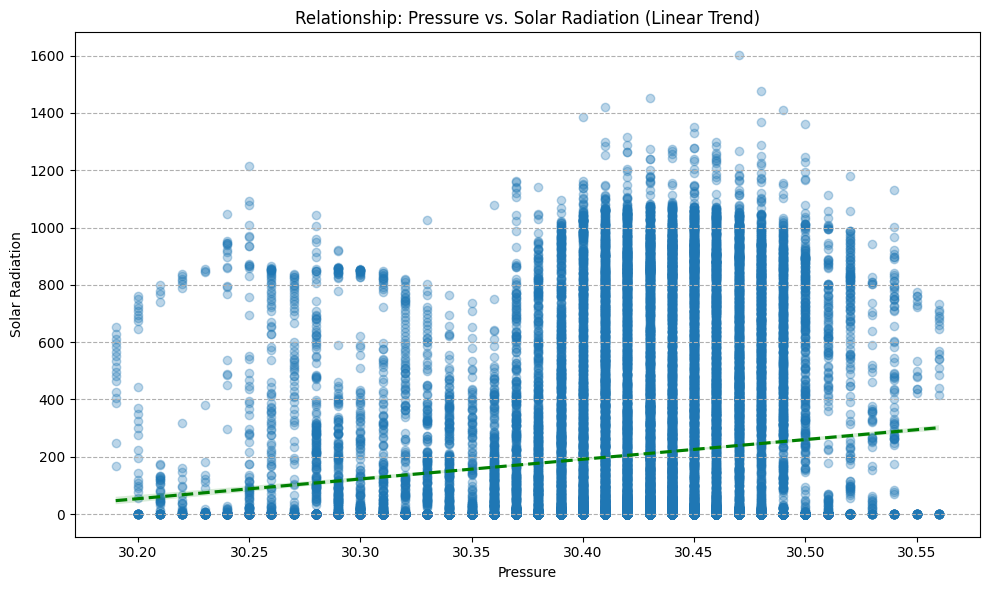

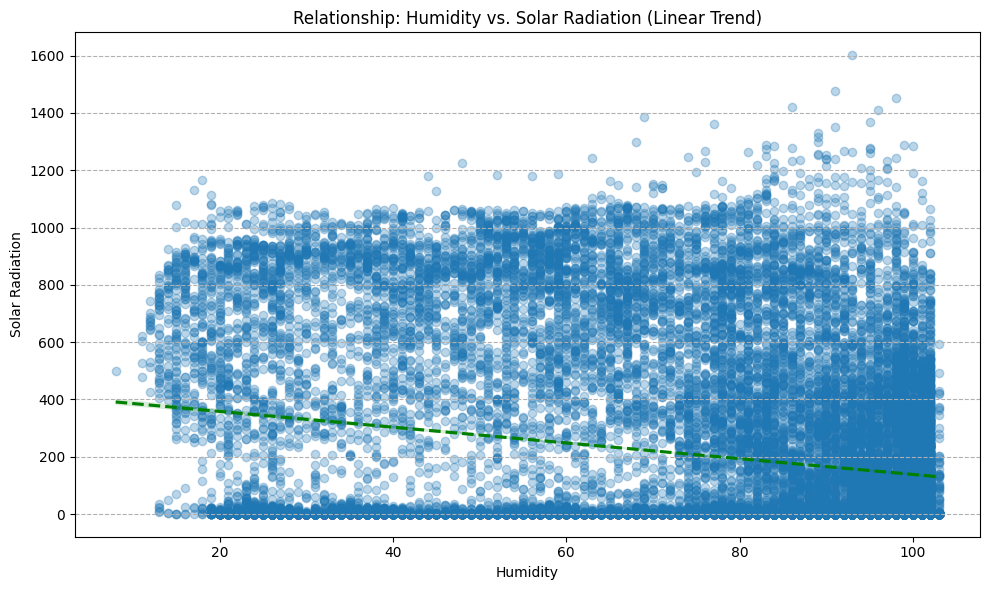

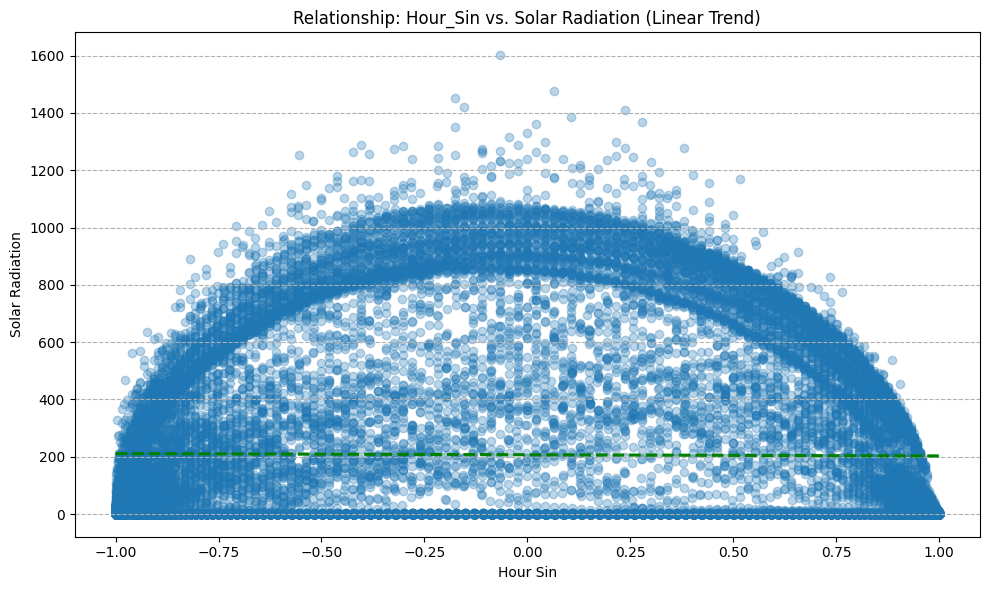

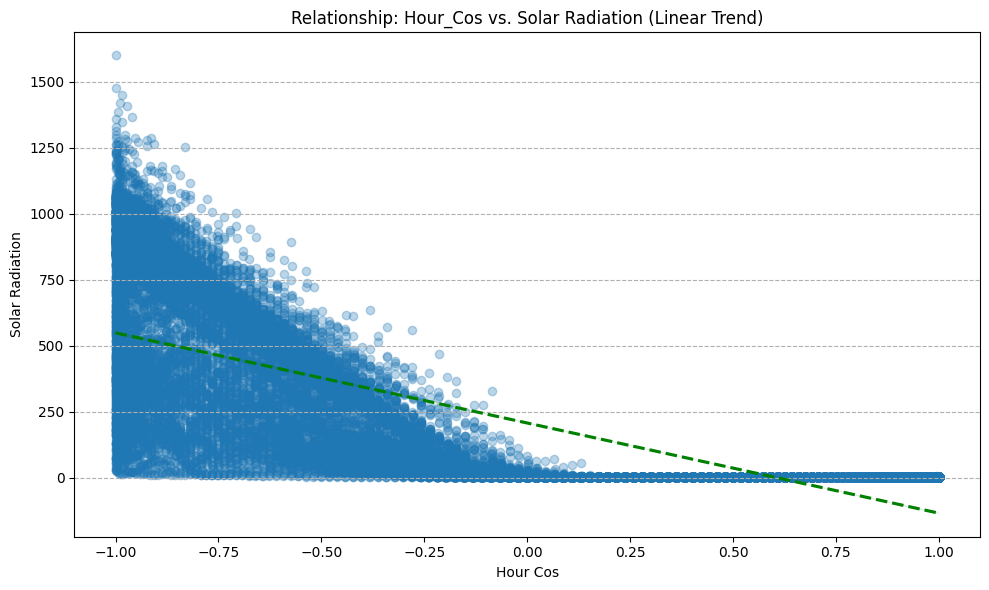

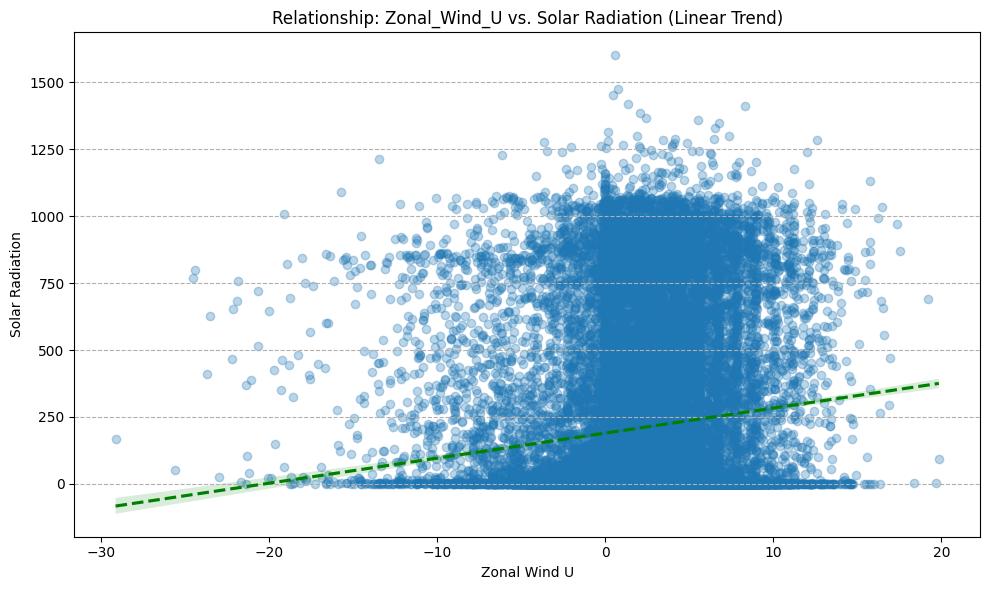

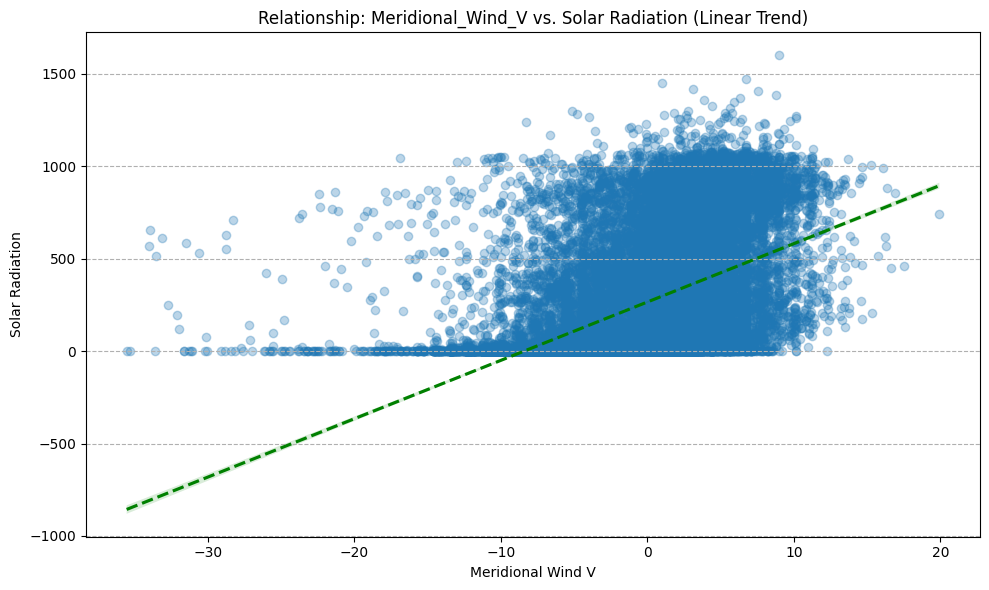

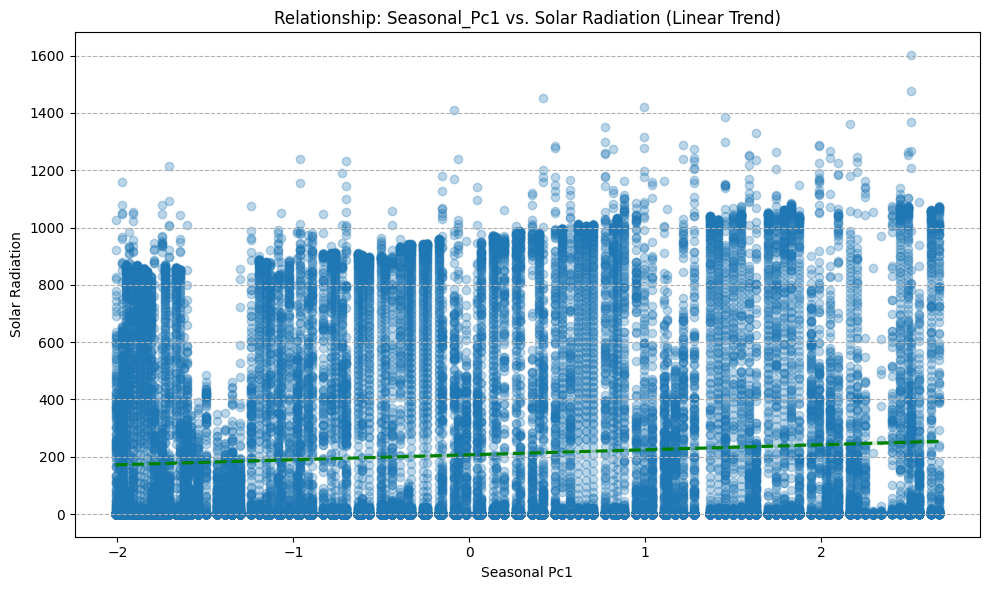

In [33]:
TARGET_COL = 'radiation'

# Get the list of features to plot (clean features only)
features_to_plot = [col for col in df.columns]

for feature in features_to_plot:
       
    plt.figure(figsize=(10, 6))
    sns.regplot(x=feature, y=TARGET_COL, data=df, scatter_kws={'alpha':0.3}, line_kws={'color': 'green', 'linestyle': '--'})
    plt.title(f'Relationship: {feature.title()} vs. Solar Radiation (Linear Trend)')

    # 2. Final Touches
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Solar Radiation')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()